In [1]:
import fenics as f
import matplotlib.pyplot as plt
from models import velocity_field, t_transport_sim, mesh_2d
import h_transport_materials as htm

----------  Running for dT=0 K  ----------*** Warning: Matplotlib plotting backend does not support mesh function of dim 1. Continuing without plotting...

Running for factor=1.0e-03
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
Running for factor=1.0e-02
  Newton iteration 0: r (abs) = 2.475e+05 (tol = 1.000e-09) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.630e-10 (tol = 1.000e-09) r (rel) = 2.275e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Running for factor=1.0e-01
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.630e-10 (tol = 1.000e-09) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
No 

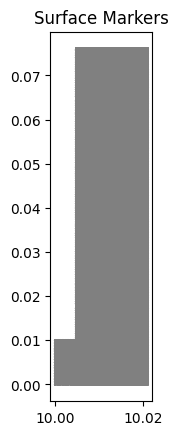

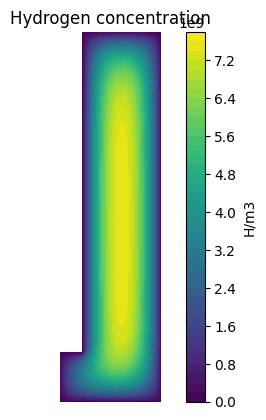

Total surface: 1.22e+01 m2
Total flux: 1.77e+05 H/s/m
Average concentration: 4.37e+09 H/m3
k: 3.31e-06 m/s
(3.314792828317611e-06, array(4.36742377e+09), 176789.75314597008)
----------  Running for dT=0.1 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


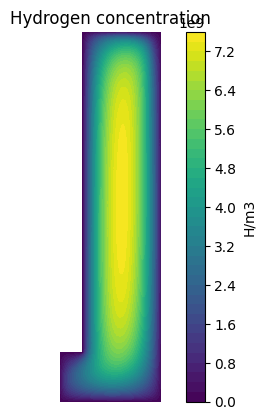

Total surface: 1.22e+01 m2
Total flux: 1.77e+05 H/s/m
Average concentration: 4.28e+09 H/m3
k: 3.38e-06 m/s
(3.379308184252803e-06, array(4.27731663e+09), 176512.13430357396)
----------  Running for dT=0.2 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


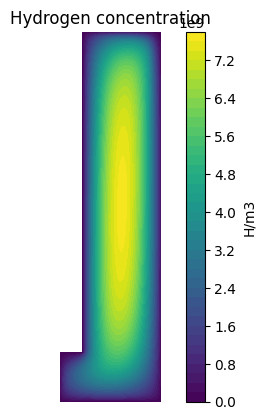

Total surface: 1.22e+01 m2
Total flux: 1.76e+05 H/s/m
Average concentration: 4.25e+09 H/m3
k: 3.40e-06 m/s
(3.397562676055597e-06, array(4.25021701e+09), 176341.26321714115)
----------  Running for dT=0.4 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


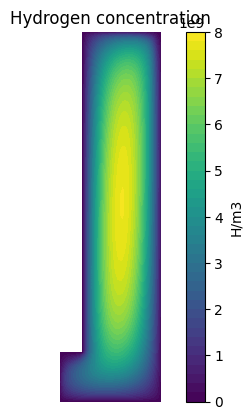

Total surface: 1.22e+01 m2
Total flux: 1.76e+05 H/s/m
Average concentration: 4.22e+09 H/m3
k: 3.42e-06 m/s
(3.4197444652774985e-06, array(4.21722322e+09), 176114.70121707267)
----------  Running for dT=0.8 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


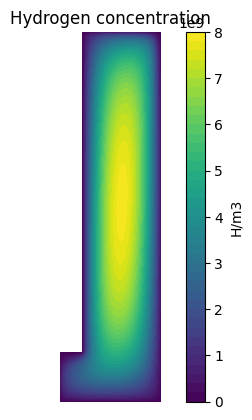

Total surface: 1.22e+01 m2
Total flux: 1.76e+05 H/s/m
Average concentration: 4.20e+09 H/m3
k: 3.43e-06 m/s
(3.4315900452267224e-06, array(4.19545962e+09), 175812.72700816623)
----------  Running for dT=2 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


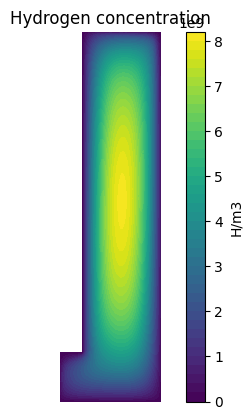

Total surface: 1.22e+01 m2
Total flux: 1.75e+05 H/s/m
Average concentration: 4.17e+09 H/m3
k: 3.44e-06 m/s
(3.4373777583357426e-06, array(4.17497067e+09), 175249.20510568612)
----------  Running for dT=3.5 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


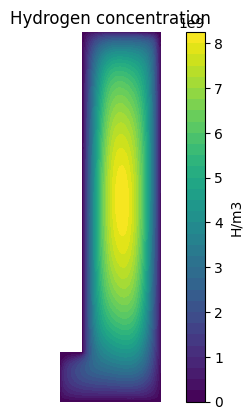

Total surface: 1.22e+01 m2
Total flux: 1.75e+05 H/s/m
Average concentration: 4.13e+09 H/m3
k: 3.47e-06 m/s
(3.465610758149837e-06, array(4.13212466e+09), 174875.33687749732)
----------  Running for dT=10 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


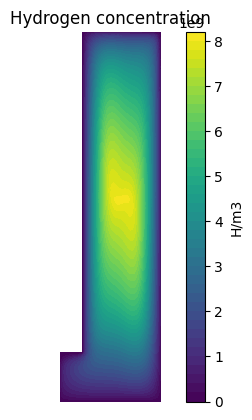

Total surface: 1.22e+01 m2
Total flux: 1.74e+05 H/s/m
Average concentration: 3.86e+09 H/m3
k: 3.71e-06 m/s
(3.7054825965163613e-06, array(3.85506766e+09), 174442.43815098642)
----------  Running for dT=0 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


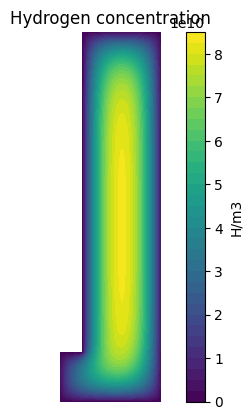

Total surface: 1.22e+01 m2
Total flux: 1.77e+05 H/s/m
Average concentration: 4.78e+10 H/m3
k: 3.03e-07 m/s
(3.025982320152585e-07, array(4.78426621e+10), 176789.75314596394)
----------  Running for dT=0.1 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


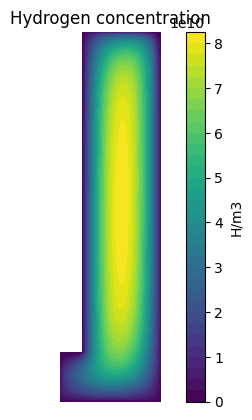

Total surface: 1.22e+01 m2
Total flux: 1.72e+05 H/s/m
Average concentration: 4.61e+10 H/m3
k: 3.06e-07 m/s
(3.0583853951244274e-07, array(4.6082185e+10), 172107.83439558413)
----------  Running for dT=0.2 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


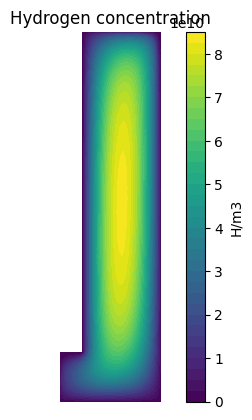

Total surface: 1.22e+01 m2
Total flux: 1.70e+05 H/s/m
Average concentration: 4.58e+10 H/m3
k: 3.03e-07 m/s
(3.0331447901408576e-07, array(4.57860649e+10), 169590.619820368)
----------  Running for dT=0.4 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


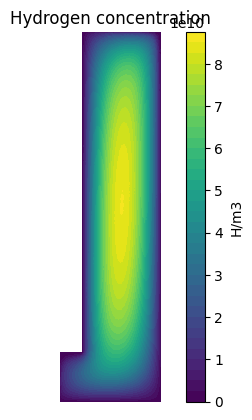

Total surface: 1.22e+01 m2
Total flux: 1.67e+05 H/s/m
Average concentration: 4.54e+10 H/m3
k: 3.01e-07 m/s
(3.0063910191624554e-07, array(4.54018347e+10), 166684.12285307905)
----------  Running for dT=0.8 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


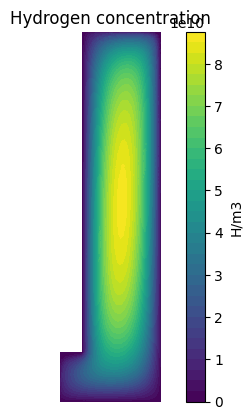

Total surface: 1.22e+01 m2
Total flux: 1.63e+05 H/s/m
Average concentration: 4.51e+10 H/m3
k: 2.96e-07 m/s
(2.962132062026968e-07, array(4.50962165e+10), 163124.7615080272)
----------  Running for dT=2 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


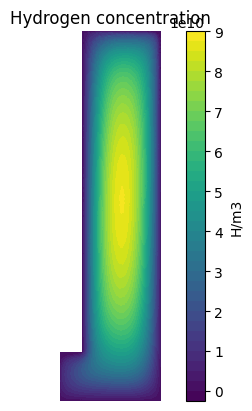

Total surface: 1.22e+01 m2
Total flux: 1.56e+05 H/s/m
Average concentration: 4.46e+10 H/m3
k: 2.86e-07 m/s
(2.8643145582189474e-07, array(4.46417486e+10), 156148.30465518564)
----------  Running for dT=3.5 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


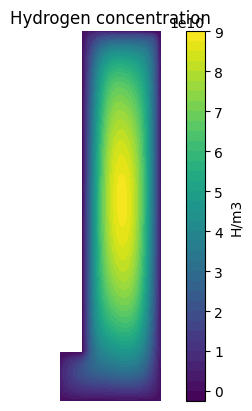

Total surface: 1.22e+01 m2
Total flux: 1.50e+05 H/s/m
Average concentration: 4.39e+10 H/m3
k: 2.80e-07 m/s
(2.797645709603315e-07, array(4.39133297e+10), 150025.28101770586)
----------  Running for dT=10 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


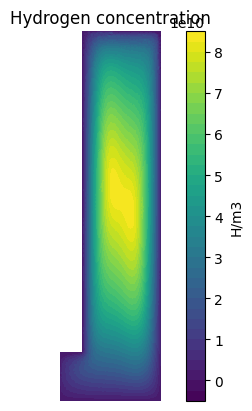

Total surface: 1.22e+01 m2
Total flux: 1.43e+05 H/s/m
Average concentration: 4.03e+10 H/m3
k: 2.91e-07 m/s
(2.9100337685942887e-07, array(4.03270543e+10), 143307.8214315897)


In [2]:
if __name__ == "__main__":
    # Generating mesh
    # x1 = 0.00476
    # x2 = 0.0162
    # y1 = 0.01
    # y2 = 0.0761
    # resolution = 30
    # mesh_fenics, surface_markers, left_id, top_id, right_id, bottom_id, upper_left_id, left_top_id = LMeshmshr(x1, x2, y1, y2, resolution)

    mesh_fenics, volume_markers, surface_markers, correspondance_dict = mesh_2d()

    T_hot = 700 + 273.15
    dt_array = [0, 0.1, 0.2, 0.4, 0.8, 2, 3.5, 10]

    diffusivities = htm.diffusivities.filter(material="flibe").filter(author=["nakamura", "anderl"])

    k_array_array = []
    for diffusivity in diffusivities:
        k_array = []
        c_array = []
        f_array = []
        for dT in dt_array:
            print(f"----------  Running for dT={dT} K  ----------")
            foldername = f"Results/dt={dT}/"
            T_cold = T_hot - dT
            u, p, T = velocity_field(
                T_cold=T_cold,
                T_hot=T_hot,
                my_mesh=mesh_fenics,
                surface_markers=surface_markers,
                correspondance_dict=correspondance_dict,
            )

            f.XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(
                T, "temperature", 1, f.XDMFFile.Encoding.HDF5
            )
            f.XDMFFile(foldername + "velocity_field.xdmf").write(u)

            # plt.figure()
            # plt.title("Velocity field")
            # CS = f.plot(u, scale=1e-3)
            # plt.colorbar(CS, label="m/s")
            # plt.axis("off")
            # plt.show()

            # plt.figure()
            # TS = f.plot(T, cmap="inferno")
            # plt.colorbar(TS, label="K")
            # plt.show()

            k = t_transport_sim(
                T,
                mesh_fenics,
                u,
                volume_markers=volume_markers,
                surface_markers=surface_markers,
                correspondance_dict=correspondance_dict,
                D_0 = diffusivity.pre_exp.magnitude, 
                E_D = diffusivity.act_energy.magnitude
            )
            print(k)
            k_array.append(k[0])
            c_array.append(k[1])
            f_array.append(k[2])

        k_array_array.append(k_array)

    # plt.figure()
    # plt.plot(dt_array, k_array, "-x", linewidth=3)
    # plt.xlabel("Temperature difference [K]")
    # plt.ylabel("Transport Coefficient [m/s]")

    # plt.figure()
    # plt.plot(dt_array, c_array, "-x", linewidth=3)
    # plt.xlabel("Temperature difference [K]")
    # plt.ylabel("Average Concentration")

    # plt.figure()
    # plt.plot(dt_array, f_array, "-x", linewidth=3)
    # plt.xlabel("Temperature difference [K]")
    # plt.ylabel("Flux")

    # xdmf_file = XDMFFile("mesh_fencis.xdmf")
    # xdmf_file.write(mesh_fenics)
    # xdmf_file.close()

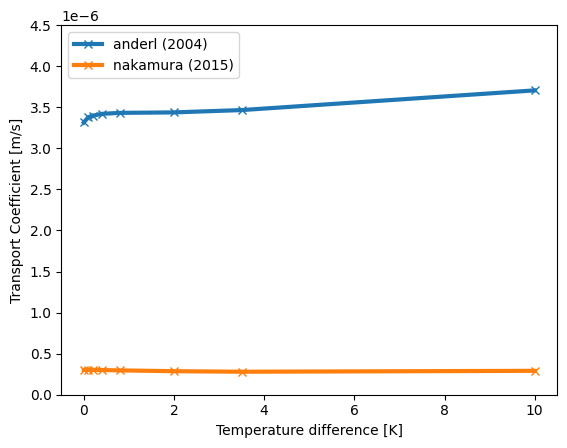

In [10]:
plt.figure()
for i in range(len(k_array_array)):
    plt.plot(dt_array, k_array_array[i], '-x', label=str(diffusivities[i].author + " (" + str(diffusivities[i].year) + ")"), linewidth=3)
plt.xlabel("Temperature difference [K]")
plt.ylabel("Transport Coefficient [m/s]")
# plt.yscale('log')
plt.ylim([0, 4.5e-06])
plt.legend(loc = "upper left")
plt.show()